In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
import glob
%matplotlib inline

In [2]:
# Show first calibration image

images = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
# Set up lists to hold object points and image points

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points. This is a 48x3 matrix
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

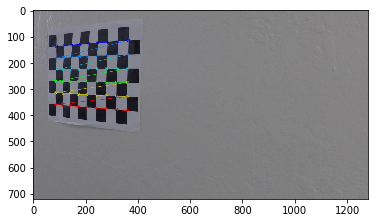

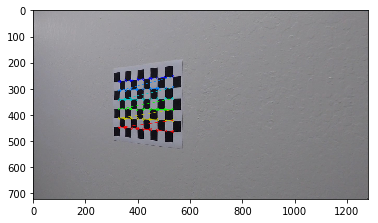

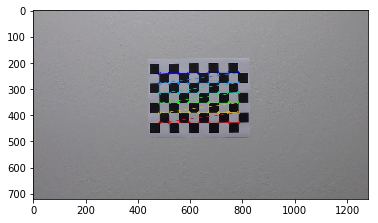

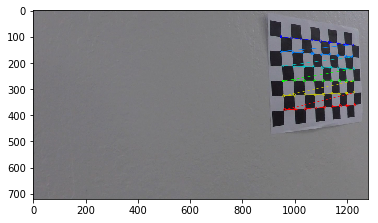

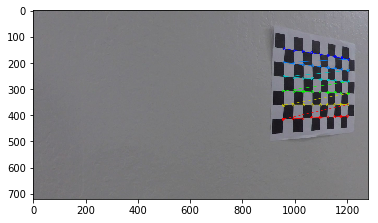

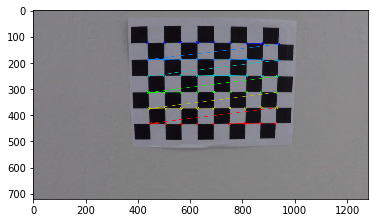

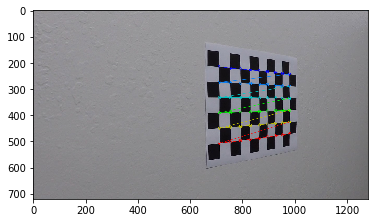

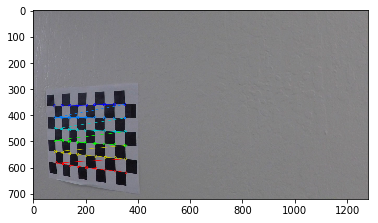

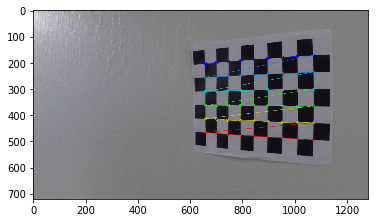

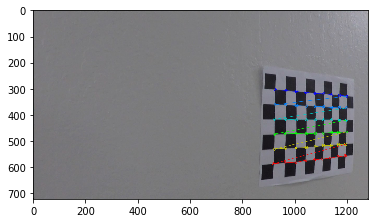

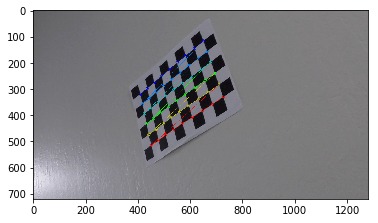

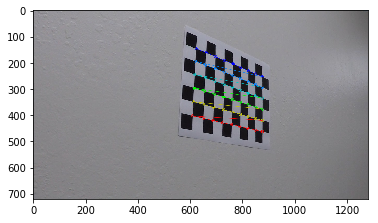

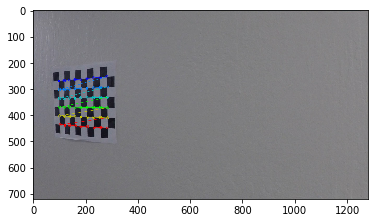

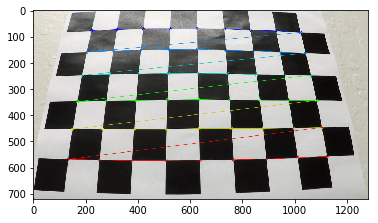

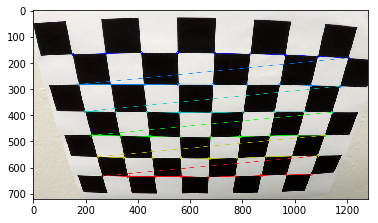

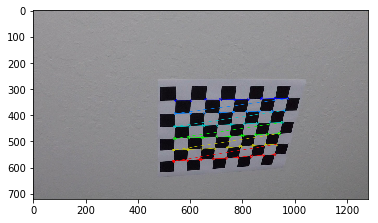

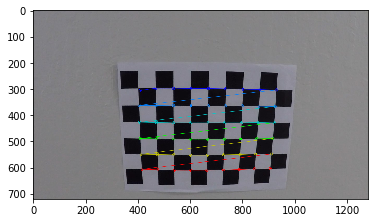

In [4]:
for fname in images:
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

In [5]:
# Return an undistorted image
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

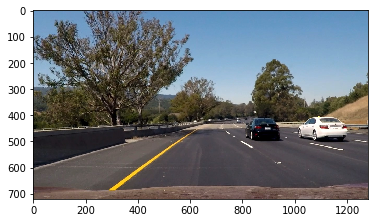

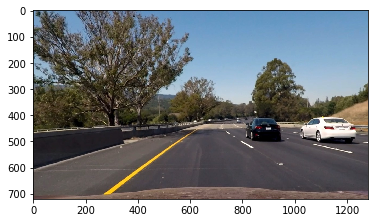

In [6]:
# Test the calibration for one image
img = mpimg.imread('./test_images/test6.jpg')
plt.imshow(img)

img = cal_undistort(img, objpoints, imgpoints)

plt.figure()
plt.imshow(img)

In [7]:
def corners_unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)

    '''
    src = np.float32([(590,450),
                  (690,450), 
                  (240,682), 
                  (1100,682)])
    dst = np.float32([(300,0),
                  (img_size[0]-300,0),
                  (300,img_size[1]),
                  (img_size[0]-300,img_size[1])])
  '''
    src = np.float32([(575,460),
                  (710,460), 
                  (260,680), 
                  (1050,680)])
    dst = np.float32([(420,0),
                  (img_size[0]-420,0),
                  (420,img_size[1]),
                  (img_size[0]-420,img_size[1])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

(1280, 720)


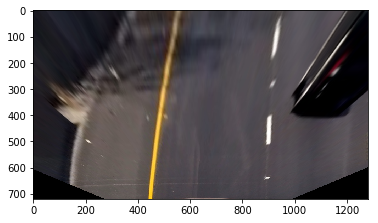

In [8]:
# Test the warping for a test image with a curved road
top_down, M, Minv = corners_unwarp(img)

plt.imshow(top_down)

In [9]:
def color_threshold(img, l_thresh=(220,255), s_thresh=(170,255), b_thresh=(190,255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    lab_b = lab[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Normalize if there is yellow in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    b_binary = np.zeros_like(lab_b)
    b_binary[(lab_b > b_thresh[0]) & (lab_b <= b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    return combined_binary
    

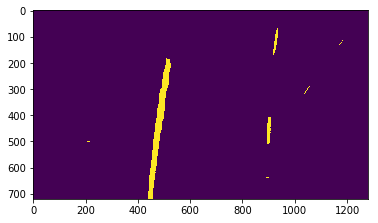

In [10]:
binary_warped = color_threshold(top_down)
plt.imshow(binary_warped)

In [11]:
# USE THIS TO PREPROCESS IMAGES
# RETURNS TOP DOWN BINARY IMAGE AND INVERSE MATRIX FOR UNDISTORTING

def preprocess(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    top_down, M, Minv = corners_unwarp(undistorted)
    
    binary_warped = color_threshold(top_down)
    
    return binary_warped, Minv

In [12]:
def polyfit(binary_warped, visualize=False):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if visualize:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

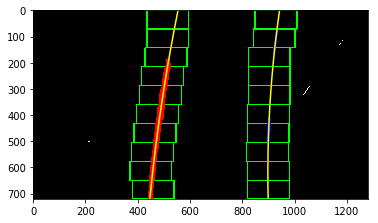

In [13]:
left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit(binary_warped, True)

In [14]:
def polyfit_prev(binary_warped, left_fit_prev, right_fit_prev, visualize=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if visualize:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

(1280, 720)


(array([ 5.95863264e-05, -9.63832437e-02,  4.90971431e+02]),
 array([ 1.46402934e-04, -1.39742354e-01,  9.24378544e+02]),
 array([False, False, False, ...,  True,  True,  True]),
 array([ True,  True,  True, ..., False, False, False]))

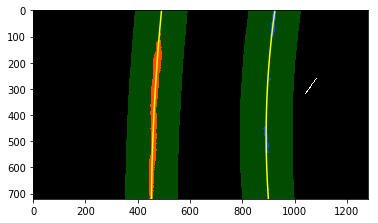

In [15]:
# Test the polyfit_prev function with a new image

img2 = mpimg.imread('./test_images/test4.jpg')

binary_warped2, Minv = preprocess(img2)

polyfit_prev(binary_warped2, left_fit, right_fit, True)

In [16]:
def draw_on_lane(img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return original_img
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

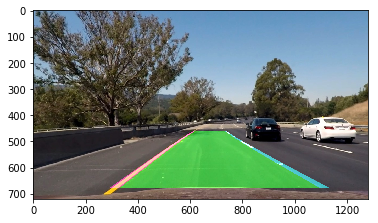

In [17]:
img_output = draw_on_lane(img, binary_warped, left_fit, right_fit, Minv)
plt.imshow(img_output)

In [18]:
def calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_rad = 0
    right_rad = 0
    distance = 0
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) > 0 and len(rightx) > 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_rad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_rad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    # Calculate how far the car is from the center of the lane
    if left_fit is not None and right_fit is not None:
        position = img_size[0] / 2
        left_x_intercept = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
        right_x_intercept = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
        lane_center = (left_x_intercept + right_x_intercept) / 2
                
        distance = (position - lane_center) * xm_per_pix
        
    return left_rad, right_rad, distance

In [19]:
left_rad, right_rad, distance = calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

In [20]:
def draw_data(img, radius, distance):
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distance > 0:
        direction = 'right'
    elif distance < 0:
        direction = 'left'
    abs_distance = abs(distance)
    text = '{:04.3f}'.format(abs_distance) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

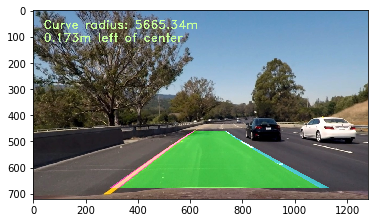

In [22]:
img_with_data = draw_data(img_output, (left_rad + right_rad)/2, distance)

plt.imshow(img_with_data)

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def add_fit(self, fit, inds):
        if fit is not None:
            

In [ ]:
# Preprocess for testing document
# images = get_all_images_from('./testing_images') this is pseudocode

# for image in images:
#     output, Minv = preprocess(image)
#     plt.imshow(output)